# The goal is to create 2  functions:

# 1. Maps convolution to dot product.
# 2. Maps dot product to convolution.

All notation is consistent with the dpf.
It's quite essential for understanding what's going on here so please read it.

In [318]:
import numpy as np
from matplotlib.pyplot import imshow, figure
from matplotlib.pyplot import plot
from matplotlib.pyplot import show

np.set_printoptions(suppress=True,
   formatter={'float_kind':'{:0.2f}'.format})


In [2]:
# essential functions

pixel = lambda local, kernel: (local * kernel).sum()
get_local = lambda image, i, j: image[i:i+5, j:j+5]

def conv(kernel, img):
    result = np.zeros_like(img)[4:, 4:]
    for i in range(0, result.shape[0]):
        for j in range(0, result.shape[1]):
            p =  pixel(get_local(img, i, j), kernel)
            result[i,j] = p
    return result

def dot(M, x):
    return M @ x

In [9]:
#useful stuff
def sqr(v):
    s = int(np.sqrt(v.shape[0] * v.shape[1]))
    return v.reshape((s,s))

def vec(m):
    return m.reshape(-1,1)

# this part is perhaps easier to understand 
# if you derive it yourself rather than read my solution
def fst_non_zero(x):
    assert x.shape[1] == 1
    j = 0
    for row in x:
        if row[0] != 0:
            return j
        j +=1
        
def row(x, summ):
    r =  np.zeros((1, x.shape[0]))
    j = fst_non_zero(x)
    r[0][j] = summ / x[j]
    return r

In [4]:
# matrix for a dot product equivalent to convlution with input imput sq(x) and output sq(y)
def matrix(x, y):
    return np.array([row(x,yy)[0] for yy in y])

# 1. Let's test if the matrix function works.

In [5]:
X = np.load("/home/const/convnet/X_test.npy").astype("float64")

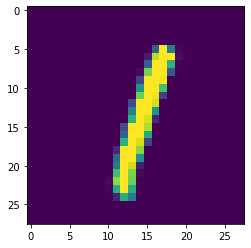

In [6]:
imshow(X[5])

In [131]:
x = vec(X[5])

In [23]:
# we have a kernel K
K = np.random.uniform(-2,2, (5,5))

# we want an equivalent matrix M
y = vec(conv(K, sqr(x)))
M = matrix(x, y)

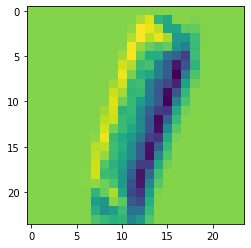

In [24]:
imshow(conv(K, sqr(x)))

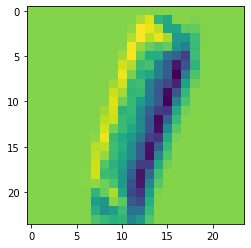

In [25]:
imshow(sqr(dot(M, x)))

In [386]:
np.allclose(conv(K, sqr(x)), sqr(dot(M, x)))

True

  # $sqr(dot(M, x)) = conv(K, sqr(x))$


# So we've got the conv to dot part: $K   ->   M$

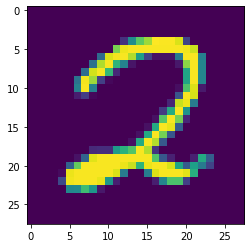

In [14]:
# Let's redefine parameters
#x = vec(X[35])
imshow(X[35])

In [33]:
# now M is known and we want K
# new M is close to the old one though
#M += np.random.uniform(-0.02, 0.02, (576, 784))
M += M*0.1
y = dot(M, x)

In [34]:
s = sqr(x)
z = sqr(y)

In [35]:
lambdas = []
for i in range(24):
    for j in range(24):
        lambdas.append(get_local(s, i, j).reshape(1,-1)[0])
        
lambdas = np.array(lambdas)
lambdas.shape

(576, 25)

In [36]:
K = sqr(np.linalg.lstsq(lambdas, y ,rcond=0)[0])

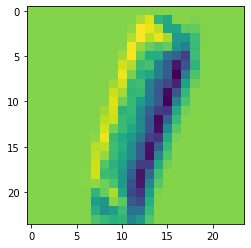

In [37]:
imshow(sqr(dot(M, x)))

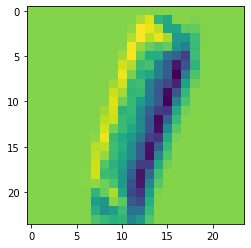

In [38]:
imshow(conv(K, sqr(x)))

In [39]:
np.allclose(conv(K, sqr(x)), sqr(dot(M, x)))

True

# $sqr(dot(M, x)) = conv(K, sqr(x))$
# Of course not all M have an equivalent K.
# I have an intuition that all the Ms we get from grad desc do have a K though.
# So hopefully we've got the dot to conv part: $M   -> K$
# Let's write a function for it:

In [319]:
def kernel(x, y):
    s = sqr(x)
    z = sqr(y)
    lambdas = []
    for i in range(24):
        for j in range(24):
            lambdas.append(get_local(s, i, j).reshape(1,-1)[0])

    lambdas = np.array(lambdas)
    K = sqr(np.linalg.lstsq(lambdas, y ,rcond=0)[0])
    return np.round(K, 2)

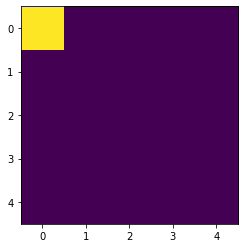

In [320]:
imshow(kernel(x, y))

# Let's try to learn an identity kernel from a random one.
https://karpathy.github.io/2019/04/25/recipe/
# Karpathy thinks if it overfits on one example it has to be not too bad.

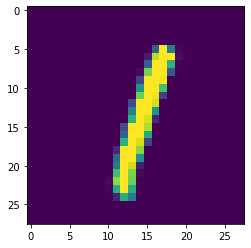

In [128]:
imshow(sqr(x))

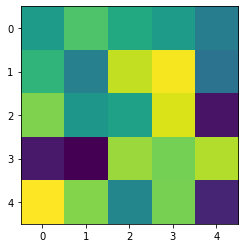

In [132]:

imshow(ran_k)

In [104]:
# generating a "dataset" of one example repeated a lot of times

data = [(x, y_hat) for _ in range(100)]


In [105]:
# one forward pass

y = vec(conv(ran_k, sqr(x)))

In [106]:
m = matrix(x, y)

In [107]:
# in terms of dot product

yy = m @ x

In [108]:
np.allclose(y, yy)

True

In [158]:
def loss(p, q):
    return ((((p - q)**2).sum()) / p.shape[0])

In [302]:
2/576

0.003472222222222222

# IT FUCKING WORKS!

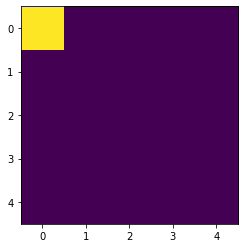

1510518.798611111
3664.7360573813867
3776.2969965277784
9.161840143453437
8.78977307241051e-30
0.0
8.78977307241051e-30
0.0
8.78977307241051e-30
0.0
8.78977307241051e-30
0.0
8.78977307241051e-30
0.0
8.78977307241051e-30
0.0
8.78977307241051e-30
0.0
8.78977307241051e-30
0.0


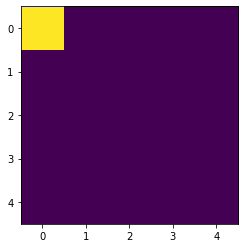

In [316]:
# x ->  m @ x = l -> loss(y_hat, l)


x = vec(X[5])



identity_kernel = np.zeros((5,5))
identity_kernel[0,0] = 1



imshow(identity_kernel)
show()
y_hat = vec(conv(identity_kernel, sqr(x)))

ran_k = np.ones((5,5))  #np.random.uniform(-1,1, (5,5))



for i in range(10):

    y = vec(conv(ran_k, sqr(x)))
    m = matrix(x, y)
    l = m @ x

    dloss_dl = 0.003472222222222222 * (l - y_hat)
    dl_dm = x
    
    dloss_dm = dloss_dl @ dl_dm.T
    print(loss(y_hat, l))

    m = m - 0.0001 * dloss_dm
    
    l = m @ x
    print(loss(y_hat, l))

    ran_k = kernel(x, l)
    

imshow(ran_k)
show()

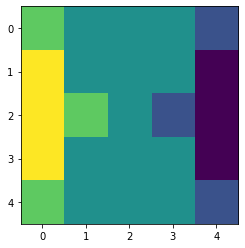

2276699.265625
5523.600168512508
5691.748164062507
13.809000421281231
4.388786631944407
0.010647828172036173
5.469463000536002e-28
0.0
5.469463000536002e-28
0.0


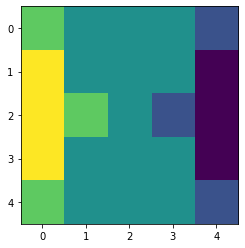

In [323]:

sobel_feldman_kernel  = np.array([[1, 0, 0, 0,-1],
                                  [2, 0, 0, 0,-2],
                                  [2, 1, 0,-1,-2],
                                  [2, 0, 0, 0,-2],
                                  [1, 0, 0, 0,-1]])


imshow(sobel_feldman_kernel)
show()
y_hat = vec(conv(sobel_feldman_kernel, sqr(x)))

ran_k = np.ones((5,5))  #np.random.uniform(-1,1, (5,5))



for i in range(5):

    y = vec(conv(ran_k, sqr(x)))
    m = matrix(x, y)
    l = m @ x

    dloss_dl = 0.003472222222222222 * (l - y_hat)
    dl_dm = x
    
    dloss_dm = dloss_dl @ dl_dm.T
    print(loss(y_hat, l))

    m = m - 0.0001 * dloss_dm
    
    l = m @ x
    print(loss(y_hat, l))

    ran_k = kernel(x, l)
    

imshow(ran_k)
show()

# FUCK YEAH 
# IT CAN LEARN FUKING ANYTHING!!!